In [2]:
import numpy as np
import pywt
import matplotlib.pyplot as plt
from itertools import combinations_with_replacement
from numpy.linalg import qr, norm
import open3d as o3d
import time
from scipy.linalg import cho_factor, cho_solve
import torch
import math


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [3]:
def slice_mesh_with_plane(mesh, plane_origin, plane_normal):
    """
    Slice a mesh with a plane and return the intersection points.
    :param mesh: open3d.geometry.TriangleMesh
    :param plane_origin: Origin of the slicing plane
    :param plane_normal: Normal vector of the slicing plane
    :return: numpy.ndarray of intersection points
    """
    # Create the plane equation: ax + by + cz + d = 0
    plane_normal = plane_normal / np.linalg.norm(plane_normal)
    d = -np.dot(plane_normal, plane_origin)

    # Collect intersection points
    intersection_points = []
    triangles = np.asarray(mesh.triangles)
    vertices = np.asarray(mesh.vertices)

    for triangle in triangles:
        # Get the vertices of the triangle
        v0, v1, v2 = vertices[triangle]

        # Check intersection of edges with the plane
        edges = [(v0, v1), (v1, v2), (v2, v0)]
        for edge in edges:
            p1, p2 = edge
            # Compute distances to the plane
            dist1 = np.dot(plane_normal, p1) + d
            dist2 = np.dot(plane_normal, p2) + d

            # If the edge intersects the plane
            if dist1 * dist2 < 0:  # Opposite signs => intersection
                t = dist1 / (dist1 - dist2)  # Parametric distance to intersection
                intersection_point = p1 + t * (p2 - p1)
                intersection_points.append(intersection_point)

    return np.array(intersection_points)

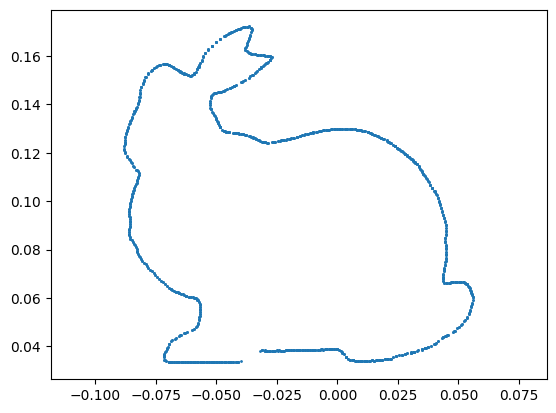

In [4]:
# Load the Stanford Bunny mesh
bunny = o3d.data.BunnyMesh()
mesh = o3d.io.read_triangle_mesh(bunny.path)
# mesh = mesh.subdivide_midpoint(number_of_iterations=1)
mesh.compute_vertex_normals()

# Define the slicing plane (e.g., z = 0.05)
plane_origin = np.array([0, 0, 0])  # A point on the plane
plane_normal = np.array([0, 0, 1])    # Plane normal (z-direction)

# Compute the intersection points
slice_points = slice_mesh_with_plane(mesh, plane_origin, plane_normal)

# Convert the slice to a 2D point cloud (x, y)
points = np.asarray(slice_points)
point_cloud_2d = points[:, :2]  # Ignore z-coordinate for 2D

# visualize the 2D point cloud
plt.figure()
plt.scatter(point_cloud_2d[:, 0], point_cloud_2d[:, 1], s=1)
plt.axis('equal')
plt.show()

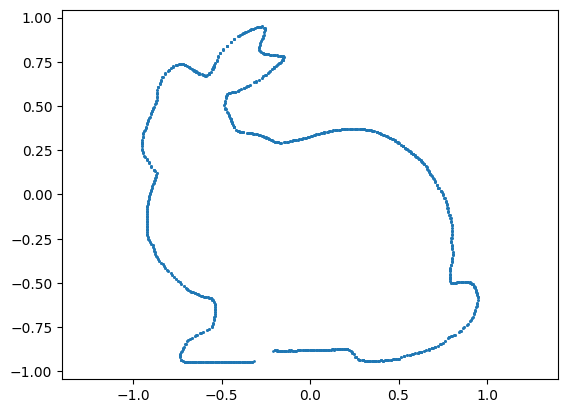

(1796, 2)


In [5]:
# Normalize the point cloud to [-1, 1]
pcl = point_cloud_2d
pcl = (pcl - pcl.min(axis=0)) / (pcl.max(axis=0) - pcl.min(axis=0))
pcl = 2 * pcl - 1
pcl = pcl * 0.95 # Scale the point cloud

# Visualize the normalized point cloud
plt.figure()
plt.scatter(pcl[:, 0], pcl[:, 1], s=1)
plt.axis('equal')
plt.show()

print(pcl.shape)


In [6]:
from copy import deepcopy
pcl_np = deepcopy(pcl)
pcl = torch.tensor(pcl, dtype=torch.double).unsqueeze(0).cuda()

### Old implementation

In [7]:

def generate_exponents(d, degree):
    """
    Generate all multi-indices with total degree up to 'degree' for d-dimensional points.
    
    Parameters:
        d (int): The dimension of the points.
        degree (int): The maximum degree of the monomials.
    
    Returns:
        ndarray: The multi-indices of shape (num_poly, d).
    """
    num_poly = math.comb(degree + d, d)
    exponents = torch.zeros(num_poly, d, dtype=int)
    i = 0
    for total_degree in range(degree + 1):
        for exps in combinations_with_replacement(range(d), total_degree):
            for var in exps:
                exponents[i, var] += 1
            i += 1
            
    return exponents

def generate_monomials_sequence_batch(X, exponents):
    """
    Generate monomials given a point cloud and multi-indices.
    
    Parameters:
        X (ndarray): An array of shape (B, N, d) representing the d-dimensional point cloud.
        exponents (ndarray): The multi-indices of shape (M, d).
    
    Returns:
        ndarray: Monomial sequences of shape (B, M).
    """
    squeeze = False
    if X.ndim == 2:
        X = X.unsqueeze(0)
        squeeze = True
    B, N, d = X.shape
    device = X.device
    exponents = exponents.to(device)
    monomials = X.unsqueeze(2).pow(exponents).prod(dim=-1)
    return monomials.squeeze(0) if squeeze else monomials

def generate_chebyshev_polynomials_sequence_batch(X, exponents):
    """
    Generate Chebyshev polynomials given a point cloud and multi-indices.

    Parameters:
        X (ndarray): An array of shape (B, N, d) representing the d-dimensional point cloud.
        exponents (ndarray): The multi-indices of shape (M, d).

    Returns:
        ndarray: Chebyshev polynomial sequences of shape (B, M).
    """
    squeeze = False
    if X.ndim == 2:
        X = X.unsqueeze(0)
        squeeze = True
    B, N, d = X.shape
    device = X.device
    exponents = exponents.to(device)
    cheby_polynomials = torch.cos(exponents.unsqueeze(0).unsqueeze(0) * torch.acos(X).unsqueeze(2)) # (B, N, M)
    cheby_polynomials = cheby_polynomials.prod(dim=-1) # (B, N)
    
    cheby_polynomials = cheby_polynomials # (B, N, M) -> (B, M)
    return cheby_polynomials.squeeze(0) if squeeze else cheby_polynomials

print(generate_chebyshev_polynomials_sequence_batch(torch.tensor(pcl, dtype=torch.double).cuda(), generate_exponents(2, 10)))

def approximate_density_torch(X, degree, poly=generate_chebyshev_polynomials_sequence_batch, grid_size=100, reg=1e-10, ax_lim=1.0, device='cuda:0'):
    """
    Approximate the density on a grid using the Christoffel function.

    Parameters:
        X (ndarray): The original point cloud of shape (N, d).
        degree (int): The maximum degree of the polynomials.
        grid_size (int): The size of the grid for visualization.

    Returns:
        ndarray: Grid of x coordinates.
        ndarray: Grid of y coordinates.
        ndarray: Estimated density values on the grid.
    """
    N, d = X.shape
    # Generate monomials at data points
    exponents = generate_exponents(d, degree)
    M_X = poly(X, exponents)
    print(M_X[:10])
    # Compute empirical covariance matrix
    time_start = time.time()
    S = (M_X.T @ M_X) / N
    # print(S[:10])
    print(f'Time for covariance computation: {time.time() - time_start:.2f}s')
    # print(S.shape)
    # Invert covariance matrix with regularization
    M = S.shape[0]
    S_reg = S + reg * torch.eye(M).to(device)
    # Use Cholesky decomposition for numerical stability
    # time_start = time.time()
    # c, lower = cho_factor(S_reg)
    # L = torch.linalg.cholesky(S_reg)
    # print(f'Time for Cholesky decomposition: {time.time() - time_start:.2f}s')
    # time_start = time.time()
    # S_inv = cho_solve((c, lower), torch.eye(M))
    # S_inv = torch.cholesky_inverse(L) #.float()
    # print(f'Time for Cholesky inverse computation: {time.time() - time_start:.2f}s')
    S_inv = torch.inverse(S_reg) #.float()
    # print(S_inv[:10])
    r = [torch.linspace(-ax_lim, ax_lim, grid_size).double().to(device) for _ in range(d)]
    grids = torch.meshgrid(*r)
    grid_points = torch.column_stack([grid.ravel() for grid in grids])
    M_grid = poly(grid_points, exponents)
    # Compute Christoffel function at grid points
    time_start = time.time()
    # print(M_grid.shape, S_inv.shape)
    # print(M_grid @ S_inv)
    # print(M_grid @ S_inv * M_grid)
    print(M_grid.dtype, S_inv.dtype)
    kappas = torch.sum(M_grid @ S_inv * M_grid, dim=1)
    # print(kappas[:10])
    print(f'Time for Christoffel function computation: {time.time() - time_start:.2f}s')
    # Compute density estimates
    densities = 1 / kappas
    # print(densities[:10])
    # make a tuple of grid_size to degree d
    densities = densities.reshape([grid_size]*d)
    # print(densities[0,0,:10])
    return grids, densities


tensor([[[ 1.0000, -0.3760,  0.6018,  ..., -0.3142,  0.1709, -0.9849],
         [ 1.0000, -0.3717,  0.6038,  ..., -0.3300,  0.1614, -0.9802],
         [ 1.0000, -0.6821,  0.7181,  ..., -0.0689, -0.5454,  0.1562],
         ...,
         [ 1.0000, -0.1851, -0.8823,  ...,  0.6624, -0.0549,  0.1881],
         [ 1.0000, -0.1851, -0.8823,  ...,  0.6624, -0.0549,  0.1881],
         [ 1.0000, -0.1843, -0.8823,  ...,  0.6631, -0.0547,  0.1876]]],
       device='cuda:0', dtype=torch.float64)


/tmp/ipykernel_3470462/1267558037.py:68: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print(generate_chebyshev_polynomials_sequence_batch(torch.tensor(pcl, dtype=torch.double).cuda(), generate_exponents(2, 10)))


### New Implementation

True


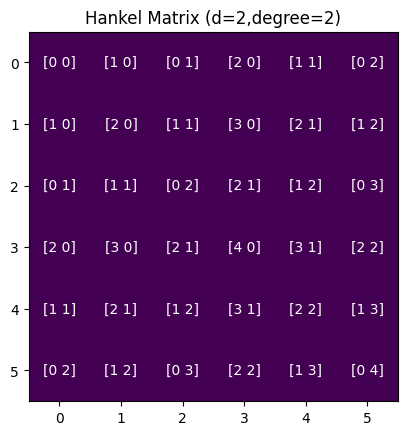

In [8]:
import numpy as np
import time
import matplotlib.pyplot as plt
from itertools import combinations_with_replacement
from scipy.linalg import cho_factor, cho_solve
import torch
import math

def generate_exponents_seq(d, degree):
    """
    Generate the moment sequence and matrix
    Parameters:
        d (int): The dimension of the points.
        degree (int): The maximum degree of the moment sequence.
    Returns:
        seq (torch.Tensor): The exponents for the moment sequence up to 2*degree.
        mat (torch.Tensor): The exponents for the moment matrix of shape s(d) x s(d).
    """
    seq_len = math.comb(degree + d, d)
    seq = torch.zeros(seq_len, d, dtype=int)
    i = 0
    for total_degree in range(degree + 1):
        for exps in combinations_with_replacement(range(d), total_degree):
            for var in exps:
                seq[i, var] += 1
            i += 1
    return seq

print(torch.allclose(generate_exponents_seq(2, 10), generate_exponents(2, 10)))

def generate_exponents_seq_and_mat(d, degree):
    """
    Generate the moment sequence and matrix
    Parameters:
        d (int): The dimension of the points.
        degree (int): The maximum degree of the moment sequence.
    Returns:
        seq (torch.Tensor): The exponents for the moment sequence up to 2*degree.
        mat (torch.Tensor): The exponents for the moment matrix of shape s(d) x s(d).
    """
    seq_len = math.comb(degree*2 + d, d)
    seq = torch.zeros(seq_len, d, dtype=int)
    i = 0
    for total_degree in range(degree*2 + 1):
        for exps in combinations_with_replacement(range(d), total_degree):
            for var in exps:
                seq[i, var] += 1
            i += 1
    mat_dim = math.comb(degree + d, d)
    mat = torch.zeros(mat_dim, mat_dim, d, dtype=int)
    for i in range(mat_dim):
        for j in range(mat_dim):
            mat[i, j] = seq[i] + seq[j]            
    return seq, mat

d = 2
degree = 2
seq, mat = generate_exponents_seq_and_mat(d, degree)
# print(seq)
# print(mat)
# visualize the Hankel matrix with text
fig, ax = plt.subplots()
im = ax.imshow(np.ones_like(mat[...,0]))
for i in range(mat.shape[0]):
    for j in range(mat.shape[1]):
        text = ax.text(j, i, str(mat[i, j].numpy()), ha='center', va='center', color='white')
plt.title('Hankel Matrix (d=%d,degree=%d)' % (d, degree))
plt.show()

In [9]:
def compute_moment_seq_and_mat(X, seq, mat, basis='cheby'):
    """
    Generate moments of specified basis given a point cloud and the exponents.
    s(n) = (d + n) C n
    Parameters:
        X (torch.Tensor): An array of shape (B, N, d) or (N, d) representing the d-dimensional point cloud.
        seq (torch.Tensor): The exponents of moment sequence of shape (s(2n), d).
        mat (torch.Tensor): The exponents of moment matrix of shape (s(n), s(n), d).
    Returns:
        mom_seq (torch.Tensor): The computed moment sequence of shape (B, s(2n))
        mom_mat (torch.Tensor): The computed moment matrix of shape (B, s(n), s(n))
    """
    squeeze = False
    if X.ndim == 2:
        X = X.unsqueeze(0)
        squeeze = True
    B, N, d = X.shape
    device = X.device
    seq, mat = seq.to(device), mat.to(device)
    if basis == 'cheby':
        # M_X = torch.cos(seq.unsqueeze(0).unsqueeze(0) * torch.acos(X).unsqueeze(2)).prod(dim=-1)
        # S = (M_X.squeeze(0).T @ M_X.squeeze(0)) / N
        # print(S)
        # assert torch.allclose(M_X.squeeze(0) if squeeze else M_X, generate_chebyshev_polynomials_sequence_batch(X, seq)), 'Mismatch in moment sequence computation'
        mom_seq = torch.cos(seq.unsqueeze(0).unsqueeze(0) * torch.acos(X).unsqueeze(2)).prod(dim=-1).sum(dim=1) / N # (B, N, M, d) -> (B, N, M) -> (B, M)
        mom_mat = torch.cos(mat.unsqueeze(0).unsqueeze(0) * torch.acos(X).unsqueeze(2).unsqueeze(2)).prod(dim=-1).sum(dim=1) / N # (B, N, M, M, d) -> (B, N, M, M) -> (B, M, M)
        # print(mom_mat)
        # assert torch.allclose(mom_mat.squeeze(0) if squeeze else mom_mat, S), 'Mismatch in moment matrix computation'
    elif basis == 'monomial':
        # M_X = (X.unsqueeze(2) ** seq.unsqueeze(0)).prod(dim=-1)
        # S = (M_X.squeeze(0).T @ M_X.squeeze(0)) / N
        # print(S)
        # assert torch.allclose(M_X.squeeze(0) if squeeze else M_X, generate_monomials_sequence_batch(X, seq)), 'Mismatch in moment sequence computation'
        mom_seq = (X.unsqueeze(2) ** seq.unsqueeze(0)).prod(dim=-1).sum(dim=1) / N
        mom_mat = (X.unsqueeze(2).unsqueeze(2) ** mat.unsqueeze(0)).prod(dim=-1).sum(dim=1) / N
        # print(mom_mat)
        # assert torch.allclose(mom_mat.squeeze(0) if squeeze else mom_mat, S), 'Mismatch in moment matrix computation'
    else:
        raise NotImplementedError
    if squeeze:
        mom_seq, mom_mat = mom_seq.squeeze(0), mom_mat.squeeze(0)
    return mom_seq, mom_mat

def compute_moment_seq(X, seq, basis='cheby'):
    """
    Generate moments of specified basis given a point cloud and the exponents.
    s(n) = (d + n) C n
    Parameters:
        X (torch.Tensor): An array of shape (B, N, d) or (N, d) representing the d-dimensional point cloud.
        seq (torch.Tensor): The exponents of moment sequence of shape (s(2n), d).
    Returns:
        mom_seq (torch.Tensor): The computed moment sequence of shape (B, s(2n))
    """
    squeeze = False
    if X.ndim == 2:
        X = X.unsqueeze(0)
        squeeze = True
    B, N, d = X.shape
    device = X.device
    seq = seq.to(device)
    if basis == 'cheby':
        mom_seq = torch.cos(seq.unsqueeze(0).unsqueeze(0) * torch.acos(X).unsqueeze(2)).prod(dim=-1).sum(dim=1) / N # (B, N, M, d) -> (B, N, M) -> (B, M)
    elif basis == 'monomial':
        mom_seq = (X.unsqueeze(2) ** seq.unsqueeze(0)).prod(dim=-1).sum(dim=1) / N
    else:
        raise NotImplementedError
    if squeeze:
        mom_seq = mom_seq.squeeze(0)
    return mom_seq

def compute_moment_mat(X, mat, basis='cheby'):
    """
    Generate moments of specified basis given a point cloud and the exponents.
    s(n) = (d + n) C n
    Parameters:
        X (torch.Tensor): An array of shape (B, N, d) or (N, d) representing the d-dimensional point cloud.
        mat (torch.Tensor): The exponents of moment matrix of shape (s(n), s(n), d).
    Returns:
        mom_mat (torch.Tensor): The computed moment matrix of shape (B, s(n), s(n))
    """
    squeeze = False
    if X.ndim == 2:
        X = X.unsqueeze(0)
        squeeze = True
    B, N, d = X.shape
    device = X.device
    mat = mat.to(device)
    if basis == 'cheby':
        mom_mat = torch.cos(mat.unsqueeze(0).unsqueeze(0) * torch.acos(X).unsqueeze(2).unsqueeze(2)).prod(dim=-1).sum(dim=1) / N # (B, N, M, M, d) -> (B, N, M, M) -> (B, M, M)
    elif basis == 'monomial':
        mom_mat = (X.unsqueeze(2).unsqueeze(2) ** mat.unsqueeze(0)).prod(dim=-1).sum(dim=1) / N
    else:
        raise NotImplementedError
    if squeeze:
        mom_mat = mom_mat.squeeze(0)
    return mom_mat


_, mat = generate_exponents_seq_and_mat(2, 2)
X = torch.tensor(pcl, dtype=torch.double).cuda()
seq = generate_exponents_seq(2, 2)
print(seq, mat)
mom_seq, mom_mat = compute_moment_seq_and_mat(X, seq, mat, basis='monomial')

tensor([[0, 0],
        [1, 0],
        [0, 1],
        [2, 0],
        [1, 1],
        [0, 2]]) tensor([[[0, 0],
         [1, 0],
         [0, 1],
         [2, 0],
         [1, 1],
         [0, 2]],

        [[1, 0],
         [2, 0],
         [1, 1],
         [3, 0],
         [2, 1],
         [1, 2]],

        [[0, 1],
         [1, 1],
         [0, 2],
         [2, 1],
         [1, 2],
         [0, 3]],

        [[2, 0],
         [3, 0],
         [2, 1],
         [4, 0],
         [3, 1],
         [2, 2]],

        [[1, 1],
         [2, 1],
         [1, 2],
         [3, 1],
         [2, 2],
         [1, 3]],

        [[0, 2],
         [1, 2],
         [0, 3],
         [2, 2],
         [1, 3],
         [0, 4]]])


/tmp/ipykernel_3470462/534660359.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(pcl, dtype=torch.double).cuda()


In [10]:
#CUDA_LAUNCH_BLOCKING=1.
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

# given sequence length, compute the moment degree n
def compute_moment_degree(seq_len, d):
    """
    Compute the degree of the moment sequence given the sequence length.
    Parameters:
        seq_len (int): The length of the moment sequence.
        d (int): The dimension of the points.
    Returns:
        degree (int): The degree of the moment sequence.
    """
    degree = 0
    while math.comb(degree + d, d) < seq_len:
        degree += 1
    
    return degree

torch.clear_autocast_cache()

seq, mat = generate_exponents_seq_and_mat(2, 2)
print(seq.device, mat.device)
mom_seq, mom_mat = compute_moment_seq_and_mat(pcl, seq, mat, basis='monomial')
print(compute_moment_degree(mom_seq.size(-1), 2))
print(mom_seq.shape, mom_mat.shape)

d = 2
degree = 0
while math.comb(degree + d, d) < mom_seq.size(-1):
    degree += 1
assert degree % 2 == 0, 'The degree of the moment sequence must be 2n.'
degree //= 2
print(degree)
exp_seq, exp_mat = generate_exponents_seq_and_mat(d, degree)
print(exp_seq.shape, exp_mat.shape)
mat_w = exp_mat.size(0)
exp_mat = exp_mat.view(-1, 1, exp_mat.size(-1))
# map from exp_seq to mom_seq
print(mom_seq.shape)
idx_mat = torch.where((exp_mat == exp_seq).all(dim=-1))[1]
# print(idx_mat.shape)
# print(mom_seq[:, idx_mat].shape)
mom_mat_rec = mom_seq[:, idx_mat].view(mat_w, mat_w)
print(torch.allclose(mom_mat_rec, mom_mat))



cpu cpu
4
torch.Size([1, 15]) torch.Size([1, 6, 6])
2
torch.Size([15, 2]) torch.Size([6, 6, 2])
torch.Size([1, 15])
True


In [11]:
import time
M = torch.diag(torch.rand(100, dtype=torch.float64).cuda())
print(torch.allclose(torch.cholesky_inverse(torch.linalg.cholesky(M)), torch.inverse(M)))
%timeit torch.cholesky_inverse(torch.linalg.cholesky(M))
%timeit torch.inverse(M)

True
2.76 ms ± 75.3 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
2.7 ms ± 77.3 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


torch.Size([1, 231]) torch.Size([1, 66, 66])


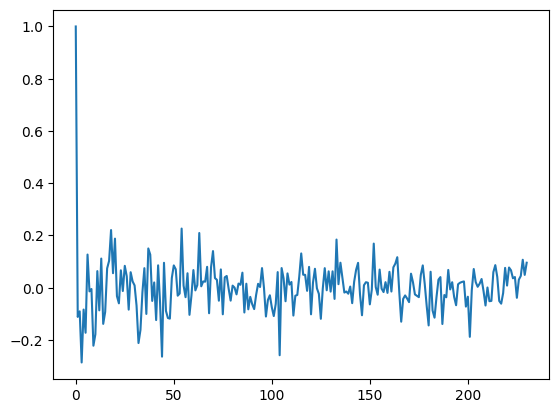

In [12]:
seq, mat = generate_exponents_seq_and_mat(2, 10)
mom_seq, mom_mat = compute_moment_seq_and_mat(pcl, *generate_exponents_seq_and_mat(2, 10), basis='cheby')
print(mom_seq.shape, mom_mat.shape)
plt.plot(mom_seq[0].cpu())

Time: 0.16328001022338867


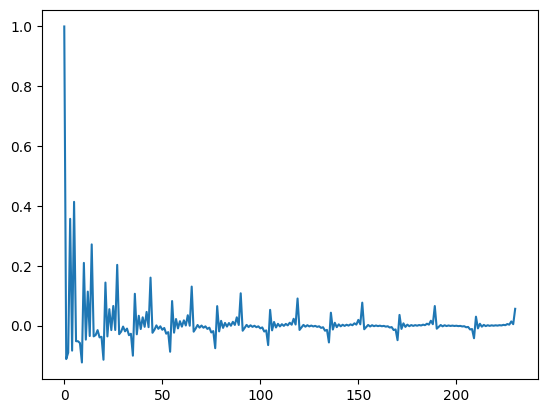

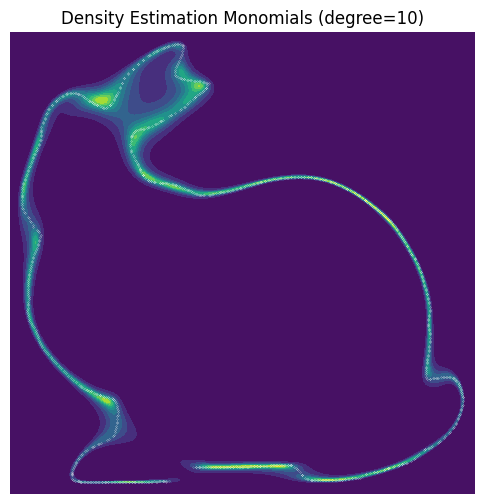

Time: 0.4794576168060303


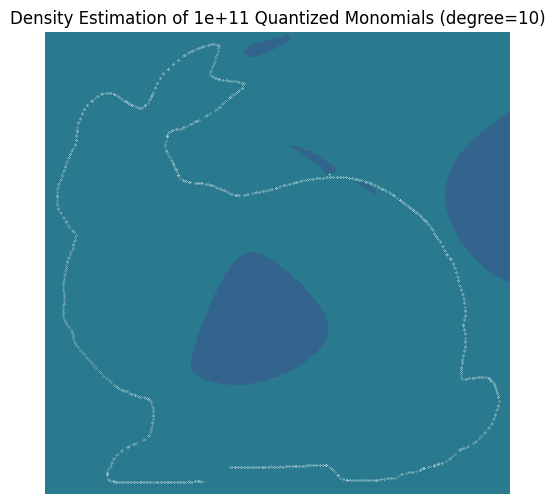

In [27]:
def MomMat2CDDensity(x_q, mom_mat, d, reg=1e-12):
    """
    Compute the density from the moment matrix.
    Parameters:
        x_q (torch.Tensor): The query points of shape (B, N, d).
        mom_mat (torch.Tensor): The moment matrix of shape (B, s(n), s(n))
        d (int): The dimension of the points.
        reg (float): The regularization strength.
    Returns:
        density (torch.Tensor): The computed density at the query points of shape (B, N).
    """
    device = mom_mat.device
    
    B, M = mom_mat.size(0), mom_mat.size(1)
    degree = 0
    while math.comb(degree + d, d) < M:
        degree += 1
    
    exp_seq = generate_exponents_seq(d, degree)
    # print("Finished gen exponents")
    
    S_reg = mom_mat + reg * torch.eye(M).repeat(B, 1, 1).to(device)
    # start = time.time()
    S_inv = torch.inverse(S_reg)
    # print('Time:', time.time() - start)
    # S_inv = torch.cholesky_inverse(torch.linalg.cholesky(S_reg))

    x_q = x_q.unsqueeze(0).repeat(B, 1, 1)
    # mom_x = torch.cos(exp_seq.unsqueeze(0).unsqueeze(0) * torch.acos(x_q).unsqueeze(2)).prod(dim=-1) # (B, N, M)
    mom_x = (x_q.unsqueeze(2) ** exp_seq.unsqueeze(0)).prod(dim=-1)
    mom_x = mom_x.to(device)
    # print(mom_x.shape, S_inv.shape)
    # kappas_old = torch.sum(mom_x.squeeze(0) @ S_inv.squeeze(0) * mom_x.squeeze(0), dim=1).unsqueeze(0)
    S_inv = S_inv.to(mom_x.dtype)
    kappas = torch.sum(torch.bmm(mom_x, S_inv) * mom_x, dim=-1)
    # assert torch.allclose(kappas_old, kappas)
    return 1 / kappas
    
def MomSeq2CDDensity(x_q, mom_seq, d, reg=1e-12):
    """
    Compute the density from the moment sequence.
    Parameters:
        x_q (torch.Tensor): The query points of shape (B, N, d).
        mom_seq (torch.Tensor): The moment sequence of shape (B, s(2n)).
        d (int): The dimension of the points.
        reg (float): The regularization strength.
    Returns:
        density (torch.Tensor): The computed density at the query points of shape (B, N).
    """
    device = mom_seq.device
    B = mom_seq.size(0)
    
    degree = 0
    while math.comb(degree + d, d) < mom_seq.size(-1):
        degree += 1
    assert degree % 2 == 0, 'The degree of the moment sequence must be 2n.'
    degree //= 2
    
    exp_seq, exp_mat = generate_exponents_seq_and_mat(d, degree)
    mat_w = exp_mat.size(0)
    exp_mat = exp_mat.view(-1, 1, exp_mat.size(-1))
    # map from exp_seq to mom_seq
    idx_mat = torch.where((exp_mat == exp_seq).all(dim=-1))[1]
    mom_mat = mom_seq[:,idx_mat].view(B, mat_w, mat_w)
    M = mom_mat.shape[0]
    exp_seq = generate_exponents_seq(d, degree)
    # print("Finished gen exponents")
    
    S_reg = mom_mat + reg * torch.eye(M).repeat(B, 1, 1).to(device)
    # start = time.time()
    S_inv = torch.inverse(S_reg)
    # print('Time:', time.time() - start)
    # S_inv = torch.cholesky_inverse(torch.linalg.cholesky(S_reg))

    x_q = x_q.unsqueeze(0).repeat(B, 1, 1)
    # mom_x = torch.cos(exp_seq.unsqueeze(0).unsqueeze(0) * torch.acos(x_q).unsqueeze(2)).prod(dim=-1) # (B, N, M)
    mom_x = (x_q.unsqueeze(2) ** exp_seq.unsqueeze(0)).prod(dim=-1)
    mom_x = mom_x.to(device)
    # print(mom_x.shape, S_inv.shape)
    # kappas_old = torch.sum(mom_x.squeeze(0) @ S_inv.squeeze(0) * mom_x.squeeze(0), dim=1).unsqueeze(0)
    S_inv = S_inv.to(mom_x.dtype)
    kappas = torch.sum(torch.bmm(mom_x, S_inv) * mom_x, dim=-1)
    # assert torch.allclose(kappas_old, kappas)
    return 1 / kappas

d = 2
degree = 10
mom_seq, mom_mat = compute_moment_seq_and_mat(pcl, *generate_exponents_seq_and_mat(d, degree), basis='monomial')
# print(mom_seq[0, :10])
# print(mom_seq.shape, mom_mat.shape)
plt.plot(mom_seq[0].cpu())


mom_mat_real = mom_mat.clone()
ax_lim = 1.0 
grid_size = 500
device = 'cuda'
r = [torch.linspace(-ax_lim, ax_lim, grid_size).double() for _ in range(d)]
grids = torch.meshgrid(*r)
grid_points = torch.column_stack([grid.ravel() for grid in grids])
# print(grid_points.shape)
start = time.time()
# density = MomMat2CDDensity(grid_points, mom_mat, 2, reg=1e-12)
# print('Time:', time.time() - start)

density = MomSeq2CDDensity(grid_points, mom_seq, 2, reg=1e-12)
print('Time:', time.time() - start)

grids = [grid.cpu() for grid in grids]
density = density.reshape([grid_size]*d).cpu()
# Plot the level sets of the density
plt.figure(figsize=(6,6))
plt.contourf(*grids, density, levels=10)
plt.scatter(pcl_np[:, 0], pcl_np[:, 1], s=0.01, color='white')
plt.title(f'Density Estimation Monomials (degree={degree})')
plt.axis('off')
plt.show()



# quantize the moment sequence values
quant_grid = 1e11
mom_seq_quant = torch.round(mom_seq * quant_grid) / quant_grid


density = MomSeq2CDDensity(grid_points, mom_seq_quant, 2, reg=1e-12)
print('Time:', time.time() - start)

grids = [grid.cpu() for grid in grids]
density = density.reshape([grid_size]*d).cpu()
# Plot the level sets of the density
plt.figure(figsize=(6,6))
plt.contourf(*grids, density, levels=10)
plt.scatter(pcl_np[:, 0], pcl_np[:, 1], s=0.01, color='white')
# plt.colorbar()
plt.title(f'Density Estimation of {quant_grid:.0e} Quantized Monomials (degree={degree})')
plt.axis('off')
plt.show()

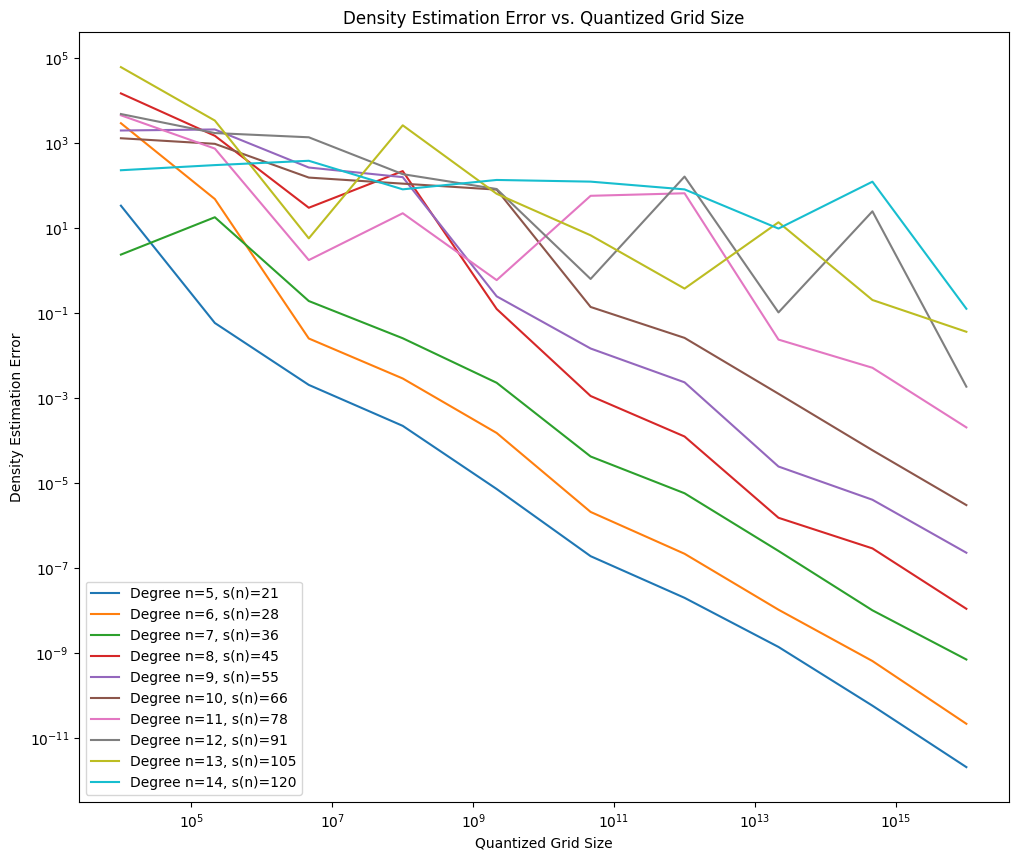

In [26]:
# eval the density error with quantization and moment degree
def eval_density_error(pcl, degree, quant_grid=100000):
    """
    Evaluate the density estimation error with quantization and moment degree.
    Parameters:
        pcl (torch.Tensor): The point cloud of shape (N, d).
        degree (int): The moment degree.
        quant_grid (int): The quantization grid size.
    Returns:
        error (float): The density estimation error.
    """
    mom_seq, _ = compute_moment_seq_and_mat(pcl, *generate_exponents_seq_and_mat(2, degree), basis='monomial')
    mom_seq_quant = torch.round(mom_seq * quant_grid) / quant_grid
    density = MomSeq2CDDensity(grid_points, mom_seq_quant, 2, reg=1e-12)
    density_gt = MomSeq2CDDensity(grid_points, mom_seq, 2, reg=1e-12)
    error = torch.norm(density - density_gt) / torch.norm(density_gt)
    return error.item()

plt.figure(figsize=(12, 10))
for degree in range(5, 15):
    # plot the density estimation for different quantization grid sizes
    q_grid = np.logspace(4, 16, num=10, base=10, dtype=int)
    error = [eval_density_error(pcl, degree, q) for q in q_grid]
    plt.plot(q_grid, error, label=f'Degree n={degree}, s(n)={math.comb(degree + 2, 2)}')
    
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Quantized Grid Size')
plt.ylabel('Density Estimation Error')
plt.legend()
plt.title('Density Estimation Error vs. Quantized Grid Size')
plt.show()
    # for q_grid in np.logspace(4, 10, num=7, base=10, dtype=int):
    #     print(f'Degree: {degree}, Quantized Grid Size: {q_grid}, Error: {eval_density_error(pcl, degree, q_grid)}')

Number of orthogonal polynomials: 136
Number of orthogonal polynomials: 136
(1000000, 136) (136, 136)
Time for Christoffel function computation: 0.87s
Minimum Christoffel function value: 47.37375586802955
Maximum Christoffel function value: 66318691963005.56


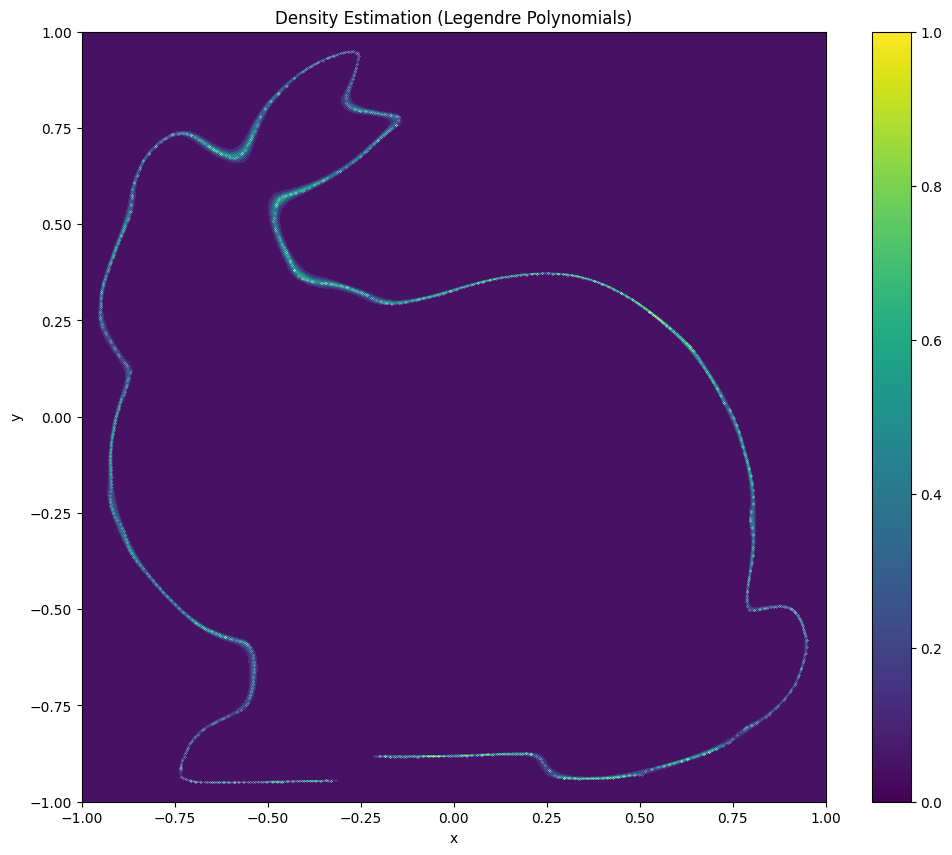

In [6]:
from functools import partial
degree = 15
# Approximate density
grids, density = approximate_density(pcl, degree, poly=partial(generate_orthogonal_polynomials, poly=chebyt), grid_size=1000, reg=1e-12)

plt.figure(figsize=(12,10))
plt.contourf(*grids, density, levels=10)
plt.scatter(pcl[:, 0], pcl[:, 1], s=0.01, color='white')
plt.colorbar()
plt.title('Density Estimation (Legendre Polynomials)')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

In [17]:
# Sample from the density
import tqdm

np.random.seed(0)

grids, density = approximate_density(pcl, degree, poly=partial(generate_orthogonal_polynomials, poly=chebyt), grid_size=1000, reg=1e-12)

print(density.min(), density.max())

# Sample from the density where the density is larger than a threshold
threshold = 0.001
samples = []
N = pcl.shape[0]
M_X = generate_orthogonal_polynomials(pcl, degree, poly=chebyt)
S = (M_X.T @ M_X) / N # (M x N) * (N x M) = M x M
M = S.shape[0]
S = S + 1e-10 * np.eye(M)
S_inv = np.linalg.inv(S)

N_samples = 2000
pbar = tqdm.tqdm(total=N_samples)
while len(samples) < N_samples:
    # Sample random points
    rand_points = np.random.uniform(-1, 1, (1000, 2))
    # Compute the density at the random points
    M_rand = generate_orthogonal_polynomials(rand_points, degree, poly=chebyt)
    kappas = np.sum(M_rand @ S_inv * M_rand, axis=1)
    densities = 1 / kappas
    # Accept samples based on the density
    accept = densities > threshold
    samples.extend(rand_points[accept])
    pbar.update(len(rand_points[accept]))


(1000000, 136) (136, 136)
Time for Christoffel function computation: 0.85s
Minimum Christoffel function value: 47.37375586802955
Maximum Christoffel function value: 66318691963005.56
1.5078705119181607e-14 0.0211087337635996



1031it [11:13,  1.53it/s] 0:00<?, ?it/s]

 99%|█████████▉| 1982/2000 [00:15<00:00, 127.74it/s]
2019it [00:15, 127.47it/s]                          

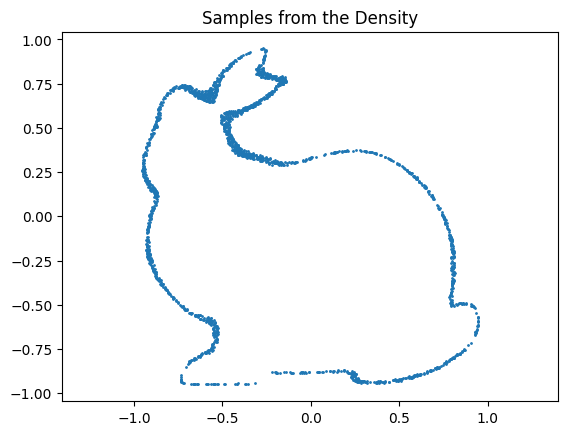


2019it [00:30, 127.47it/s]

In [18]:
samples = np.array(samples)

# Visualize the samples
plt.figure()
plt.scatter(samples[:, 0], samples[:, 1], s=1)
plt.axis('equal')
plt.title('Samples from the Density')
plt.show()

In [ ]:
import trimesh